In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from pandas_datareader import data as pdr

In [55]:
TMFsim = pd.read_csv("./data/TMFSIM.csv")
UPROsim = pd.read_csv("./data/UPROSIM.csv")

UPROsim["UPRO"] = UPROsim["UPRO"].str.replace("%", "").astype("float")
TMFsim["TMF"] = TMFsim["TMF"].str.replace("%", "").astype("float")
UPROsim

,Date,UPRO,Unnamed: 2
0,5/20/86,3.7,NaN
1,5/21/86,-0.7,NaN
2,5/22/86,5.9,NaN
3,5/23/86,1.4,NaN
4,5/27/86,4.2,NaN
...,...,...,...
8252,2/14/19,-0.7,NaN
8253,2/15/19,3.3,NaN
8254,2/19/19,0.4,NaN
8255,2/20/19,0.6,NaN


In [56]:
TMFsim['Date'] = pd.to_datetime(TMFsim['Date'], format='%m/%d/%y')
UPROsim['Date'] = pd.to_datetime(UPROsim['Date'], format='%m/%d/%y')

display(TMFsim.head())

,Date,TMF,Unnamed: 2
0,1986-05-20,-0.6,NaN
1,1986-05-21,3.0,NaN
2,1986-05-22,-0.6,NaN
3,1986-05-23,0.6,NaN
4,1986-05-27,1.3,NaN


In [57]:
spy = yf.Ticker("SPY")
spy.info

{'longBusinessSummary': 'The Trust seeks to achieve its investment objective by holding a portfolio of the common stocks that are included in the index (the “Portfolio”), with the weight of each stock in the Portfolio substantially corresponding to the weight of such stock in the index.',
 'maxAge': 86400,
 'priceHint': 2,
 'previousClose': 508.08,
 'open': 508.98,
 'dayLow': 508.56,
 'dayHigh': 513.29,
 'regularMarketPreviousClose': 508.08,
 'regularMarketOpen': 508.98,
 'regularMarketDayLow': 508.56,
 'regularMarketDayHigh': 513.29,
 'trailingPE': 25.83455,
 'volume': 76610613,
 'regularMarketVolume': 76610613,
 'averageVolume': 77466765,
 'averageVolume10days': 64578110,
 'averageDailyVolume10Day': 64578110,
 'bid': 512.01,
 'ask': 512.14,
 'bidSize': 1000,
 'askSize': 1400,
 'yield': 0.0137,
 'totalAssets': 483743596544,
 'fiftyTwoWeekLow': 380.65,
 'fiftyTwoWeekHigh': 513.29,
 'fiftyDayAverage': 486.4008,
 'twoHundredDayAverage': 451.1977,
 'trailingAnnualDividendRate': 5.662,
 't

In [58]:
HFEA = yf.Tickers("spy tlt")
spy = HFEA.tickers["SPY"]
tlt = HFEA.tickers["TLT"]

In [59]:
yf.pdr_override()
real_data = yf.download("SPY TLT")

[*********************100%%**********************]  2 of 2 completed


In [60]:
real_data

Price        Adj Close                  Close                   High  \
Ticker             SPY        TLT         SPY        TLT         SPY   
Date                                                                   
1993-01-29   24.840685        NaN   43.937500        NaN   43.968750   
1993-02-01   25.017347        NaN   44.250000        NaN   44.250000   
1993-02-02   25.070351        NaN   44.343750        NaN   44.375000   
1993-02-03   25.335375        NaN   44.812500        NaN   44.843750   
1993-02-04   25.441370        NaN   45.000000        NaN   45.093750   
...                ...        ...         ...        ...         ...   
2024-02-26  505.989990  93.296844  505.989990  93.589996  508.750000   
2024-02-27  506.929993  92.638916  506.929993  92.930000  507.160004   
2024-02-28  506.260010  93.227066  506.260010  93.519997  506.859985   
2024-02-29  508.079987  93.885002  508.079987  94.180000  509.739990   
2024-03-01  512.849976  94.470001  512.849976  94.470001  513.289978   

Price                         Low                   Open               Volume  \
Ticker            TLT         SPY        TLT         SPY        TLT       SPY   
Date                                                                            
1993-01-29        NaN   43.750000        NaN   43.968750        NaN   1003200   
1993-02-01        NaN   43.968750        NaN   43.968750        NaN    480500   
1993-02-02        NaN   44.125000        NaN   44.218750        NaN    201300   
1993-02-03        NaN   44.375000        NaN   44.406250        NaN    529400   
1993-02-04        NaN   44.468750        NaN   44.968750        NaN    531500   
...               ...         ...        ...         ...        ...       ...   
2024-02-26  94.029999  505.859985  93.190002  508.299988  94.000000  50386700   
2024-02-27  93.470001  504.750000  92.849998  506.700012  93.239998  48854500   
2024-02-28  93.599998  504.959991  92.900002  505.329987  93.080002  56506600   
2024-02-29  94.300003  505.350006  93.779999  508.070007  93.820000  83924800   
2024-03-01  94.510002  508.559998  93.010002  508.980011  93.440002  76805900   

Price                   
Ticker             TLT  
Date                    
1993-01-29         NaN  
1993-02-01         NaN  
1993-02-02         NaN  
1993-02-03         NaN  
1993-02-04         NaN  
...                ...  
2024-02-26  27855000.0  
2024-02-27  30242000.0  
2024-02-28  34574200.0  
2024-02-29  51038600.0  
2024-03-01  45822800.0  

[7828 rows x 12 columns]

In [61]:
real_data.columns

MultiIndex([('Adj Close', 'SPY'),
            ('Adj Close', 'TLT'),
            (    'Close', 'SPY'),
            (    'Close', 'TLT'),
            (     'High', 'SPY'),
            (     'High', 'TLT'),
            (      'Low', 'SPY'),
            (      'Low', 'TLT'),
            (     'Open', 'SPY'),
            (     'Open', 'TLT'),
            (   'Volume', 'SPY'),
            (   'Volume', 'TLT')],
           names=['Price', 'Ticker'])

In [62]:
def calculate_pct_change_for_tickers(df, tickers):
    """
    Calculate the daily percentage change of the 'Close' price for a given list of tickers.

    Parameters:
    - df: DataFrame with MultiIndex columns ('Price', 'Ticker').
    - tickers: List of string, the ticker symbols of the stocks.

    Returns:
    - DataFrame with the date, and the daily percentage change of the 'Close' price for the specified tickers.
    """
    pct_change_list = []

    for ticker in tickers:
        if ('Close', ticker) in df.columns:
            # Calculate percentage change for the specified ticker's 'Close' price
            pct_change_series = df['Close', ticker].pct_change() * 100  # Multiply by 100 to convert to percentage
            pct_change_series.name = f'{ticker}_Pct_Change'  # Rename the Series for clarity
            pct_change_list.append(pct_change_series)

    # Concatenate all the percentage change Series into a single DataFrame
    if pct_change_list:
        pct_change_df = pd.concat(pct_change_list, axis=1)
        pct_change_df.index.name = 'Date'  # Assuming the DataFrame's index is Date
        # Reset index to turn the Date index into a column
        pct_change_df.reset_index(inplace=True)
        return pct_change_df
    else:
        return pd.DataFrame()  # Return an empty DataFrame if no tickers were found or provided

In [63]:
tickers = ['SPY', 'TLT']
pct_change_df = calculate_pct_change_for_tickers(real_data, tickers)
print(pct_change_df)

           Date  SPY_Pct_Change  TLT_Pct_Change
0    1993-01-29             NaN             NaN
1    1993-02-01        0.711238             NaN
2    1993-02-02        0.211864             NaN
3    1993-02-03        1.057082             NaN
4    1993-02-04        0.418410             NaN
...         ...             ...             ...
7823 2024-02-26       -0.366253       -0.298292
7824 2024-02-27        0.185775       -0.705199
7825 2024-02-28       -0.132165        0.634883
7826 2024-02-29        0.359494        0.705735
7827 2024-03-01        0.938826        0.307922

[7828 rows x 3 columns]


In [64]:
pct_change_df['Date'] = pd.to_datetime(pct_change_df['Date'])

joined_df = pd.merge(pct_change_df, TMFsim, on='Date', how='outer')

final_joined_df = pd.merge(joined_df, UPROsim, on='Date', how='outer', suffixes=('_real', '_sim'))

final_joined_df.sort_values(by='Date', inplace=True)
final_joined_df[4000:6000]

,Date,SPY_Pct_Change,TLT_Pct_Change,TMF,Unnamed: 2_real,UPRO,Unnamed: 2_sim
4000,2002-03-26,0.580931,NaN,2.0,NaN,1.8,NaN
4001,2002-03-27,0.262539,NaN,0.0,NaN,1.6,NaN
4002,2002-03-28,-0.043644,NaN,-0.6,NaN,0.7,NaN
4003,2002-04-01,0.043663,NaN,0.0,NaN,-0.3,NaN
4004,2002-04-02,-0.549880,NaN,2.3,NaN,-2.6,NaN
...,...,...,...,...,...,...,...
5995,2010-02-26,0.063251,0.515352,1.8,NaN,0.4,NaN
5996,2010-03-01,1.038470,-0.359989,0.3,NaN,3.0,NaN
5997,2010-03-02,0.277056,-0.131372,-0.3,NaN,0.7,NaN
5998,2010-03-03,0.089132,-0.252141,-0.5,NaN,0.2,NaN


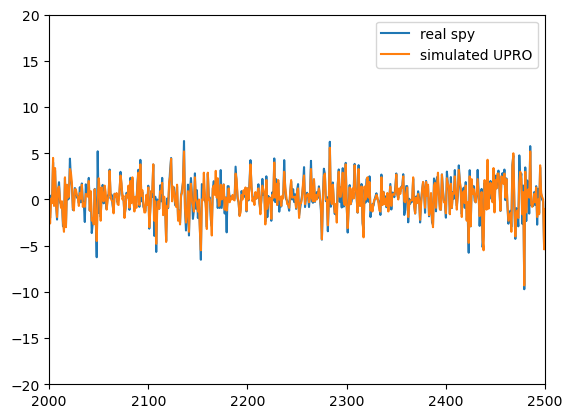

In [70]:
plt.plot(final_joined_df["SPY_Pct_Change"] * 3, label="real spy")
plt.plot(final_joined_df["UPRO"], label = "simulated UPRO")
plt.legend()
plt.ylim(-20,20)
plt.xlim(2000,2500)
plt.show()

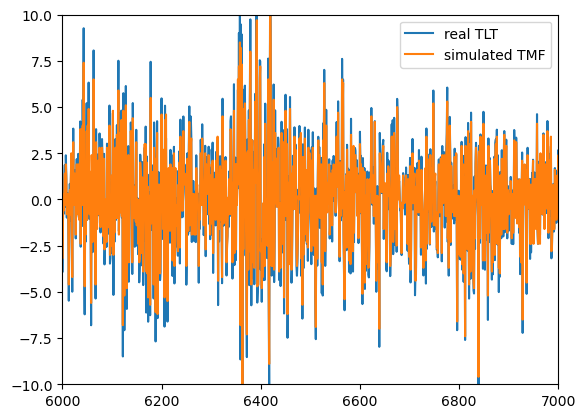

In [75]:
plt.plot(final_joined_df["TLT_Pct_Change"] * 3, label="real TLT")
plt.plot(final_joined_df["TMF"], label = "simulated TMF")
plt.legend()
plt.xlim(6000,7000)
plt.ylim(-10,10)
plt.show()